In [265]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [266]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [267]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Pow supported only for int & float datatypes"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        t = (math.exp(x)) * out.grad
        out = Value(t, (self, ), 'exp')
        def _backward():
            self.grad += math.exp(x)
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


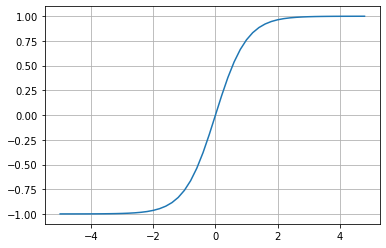

In [268]:
plt.plot(np.arange(-5.0, 5.0, 0.2), np.tanh(np.arange(-5.0, 5.0, 0.2)))
plt.grid()

In [269]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [270]:
o.backward()

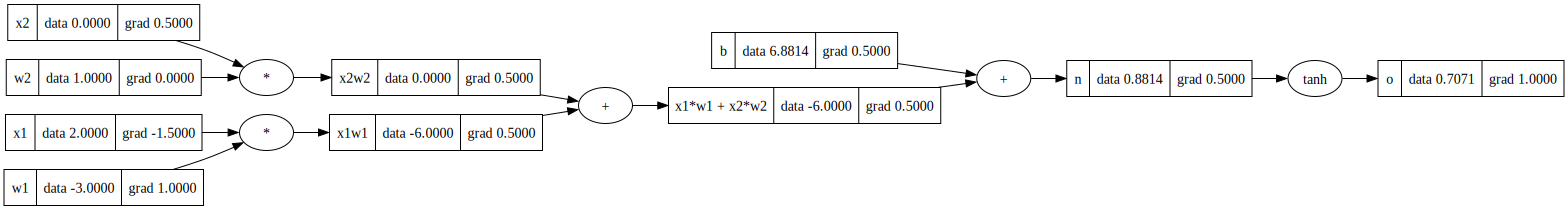

In [271]:
draw_dot(o)

In [272]:
import random
from typing import Any

class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x) -> Any:
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x) -> Any:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        print(sz)
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [273]:
x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
n(x)

[3, 4, 4, 1]


Value(data=-0.33273012580857697)

In [274]:
xs = [
    [2.0, 3.0, -1.0],
    [0.0, 1.0, 1.0],
    [2.5, 0.5, -1.0],
    [2.0, 1.0, 2.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

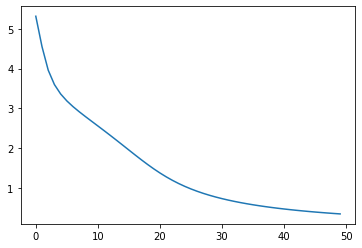

In [275]:
epochs = 50
losses = []
for epoch in range(epochs):
    
    # forward
    
    ypreds = [n(x) for x in xs]
    loss = sum((ypred - ygt)**2 for ygt, ypred in zip(ys, ypreds))
    losses.append(loss)
    
    # backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # optimize
    for p in n.parameters():
        p.data += -1e-2 * p.grad    

plt.plot(list(range(epochs)), [loss.data for loss in losses])